In [2]:
!nvidia-smi

Sat Feb 19 08:02:21 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from keras.datasets import mnist
from keras.layers import (
    Activation, BatchNormalization, Dense, Dropout, Flatten, Reshape)
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.models import Sequential

In [4]:
img_rows = 28
img_cols = 28
channels = 1

img_shape = (img_rows, img_cols, channels)

z_dim = 100

In [5]:
def build_generator(z_dim):
    
    model = Sequential()
    
    model.add(Dense(256*7*7, input_dim=z_dim))
    model.add(Reshape((7,7,256)))
    
    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))
    
    model.add(BatchNormalization())
    
    model.add(LeakyReLU(alpha=0.01))
    
    model.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding='same'))
    
    model.add(BatchNormalization())
    
    model.add(LeakyReLU(alpha=0.01))
    
    model.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same'))
    
    model.add(Activation('tanh'))
    
    return model

In [6]:
def build_discriminator(img_shape):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding='same'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=img_shape, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2D(128, kernel_size=3, strides=2, input_shape=img_shape, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

In [7]:
def build_gan(generator, discriminator):
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])

generator = build_generator(z_dim)

discriminator.trainable = False

gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer='Adam')

In [8]:
def sample_images(generator, image_grid_rows=4, image_grid_cols=4):
    z = np.random.normal(0,1,(image_grid_rows*image_grid_cols, z_dim))
    gen_imgs = generator.predict(z)
    gen_imgs = 0.5*gen_imgs + 0.5
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_cols,
                            figsize=(4,4),
                            sharey=True,
                            sharex=True)
    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_cols):
            axs[i,j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1

In [9]:
losses = []
accuracies = []
iteration_checkpoints = []

def train(iterations, batch_size, sample_interval):
    (x_train, _), (_, _) = mnist.load_data()
    
    x_train = x_train / 127.5 - 1.0
    x_train = np.expand_dims(x_train, axis=3)
    
    real = np.ones((batch_size,1))
    fake = np.zeros((batch_size,1))
    
    for iteration in range(iterations):
        idx = np.random.randint(0, x_train.shape[0], batch_size)
        imgs = x_train[idx]
        
        z = np.random.normal(0,1,(batch_size,100))
        gen_imgs = generator.predict(z)
        
        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        z = np.random.normal(0,1,(batch_size,100))
        gen_imgs = generator.predict(z)
        
        g_loss = gan.train_on_batch(z, real)
        
        if (iteration+1)%sample_interval ==0:
            losses.append((d_loss, g_loss))
            accuracies.append(100.0*accuracy)
            iteration_checkpoints.append(iteration+1)
            
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (iteration+1, d_loss, 100.0*accuracy,
                                                                  g_loss))
            sample_images(generator)

11501568/11490434 [==============================] - 0s 0us/step
1000 [D loss: 0.000006, acc.: 100.00%] [G loss: 0.008254]
2000 [D loss: 0.000001, acc.: 100.00%] [G loss: 0.005837]
3000 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.010881]
4000 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.040415]
5000 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.024845]
6000 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.028772]
7000 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.040452]
8000 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.092362]
9000 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.139206]
10000 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.174448]
11000 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.188200]
12000 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.176329]
13000 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.277283]
14000 [D loss: 0.000000, acc.: 100.00%] [G loss: 0.858091]
15000 [D loss: 0.000000, acc.: 100.00%] [G loss: 1.313623]
16000 [D loss: 0.000000, acc.: 100.00%] [G loss: 1.678522]


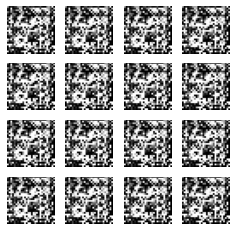

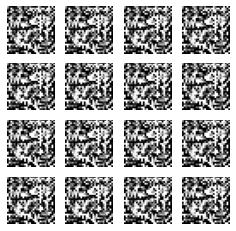

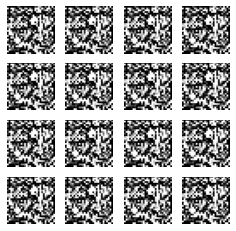

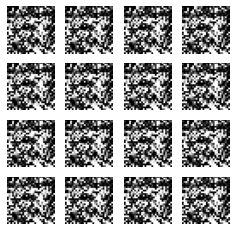

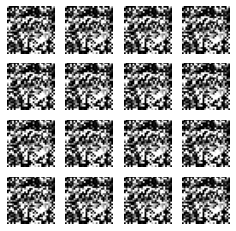

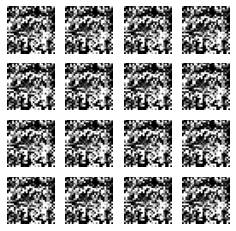

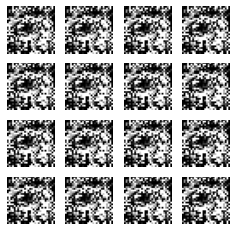

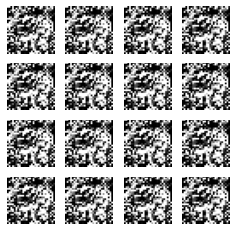

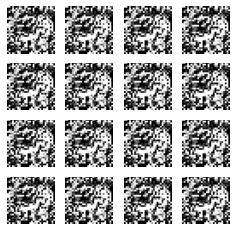

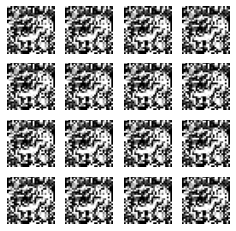

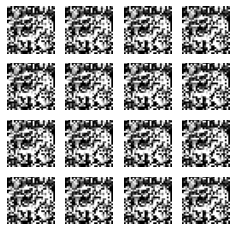

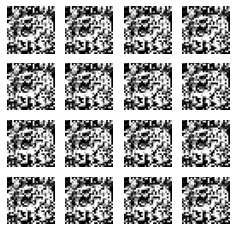

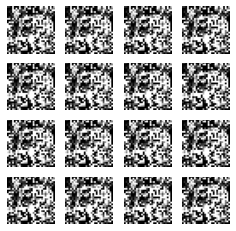

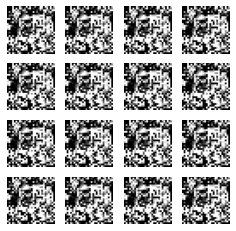

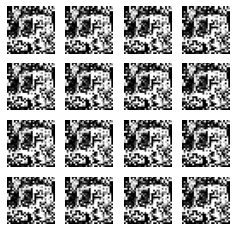

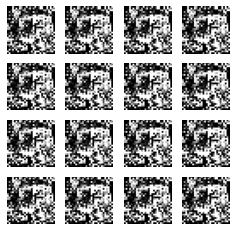

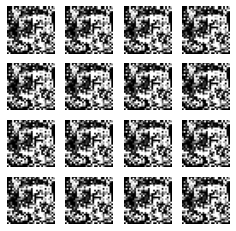

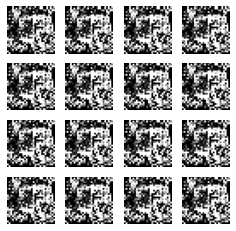

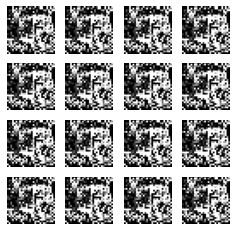

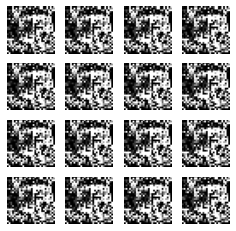

In [10]:
iterations = 20000
batch_size = 128
sample_interval = 1000

train(iterations, batch_size, sample_interval)